In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import Tensor

from torch import nn, optim
from torch.distributions import Distribution

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from arff2pandas import a2p
import dill

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [2]:
from VAE.models import BaseVAEprob, BaseLSTM_VAEprob, Neural_Stat
from generators.generate_data_tfh import SERSGenerator
from utils import plot_sequences

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

C:\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
loc = np.array([
    [5, 3],
    [8, 9]
])
c_norm = np.array([25, 75])
c_outlier = np.array([10, 45])
gen_data = SERSGenerator([10, 10], 120, hotspot_loc=loc, c=c_norm, seed=42)
gen_outlier = SERSGenerator([10, 10], 120, hotspot_loc=loc, c=c_outlier, seed=42)

train_dataset = []
outlier_dataset = []

for i in range(15):

    X = gen_data.generate(N_hotspots=gen_data.hotspot_loc.shape[0], sig=0.1, sbr=1.5, K=len(gen_data.c), plot=False)
    X = torch.from_numpy(X).float()

    train_dataset.append(X)

    if i == 0:
        X_outlier = gen_outlier.generate(N_hotspots=gen_outlier.hotspot_loc.shape[0], sig=0.1, sbr=1.5, K=len(gen_outlier.c), plot=False)
        X_outlier = torch.from_numpy(X_outlier).float()
        outlier_dataset.append(X_outlier)

        gen_data.seed = None
        gen_outlier.seed = None

        

train_dataset = torch.cat([s for s in train_dataset])
train_dataset = train_dataset.unsqueeze(2)

outlier_dataset = torch.cat([s for s in outlier_dataset])
outlier_dataset = outlier_dataset.unsqueeze(2)

### Load NS

In [4]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, hidden_dim=50, num_layers=1, bidirectional=True,
                 latent_z:int=1, z_layers:int=1, latent_c:int=1):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        #(batch, hidden)
        x, (hidden_n, _) = self.lstm(x)

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]

        hidden_n = hidden_n.reshape(batch_size, -1)
        #print(hidden_n.shape)
        return hidden_n
class Decoder(nn.Module):
    def __init__(self, latent_z:int, z_layers:int, latent_c:int,
                 seq_len, n_features=1, hidden_dim=50, num_layers=1, bidirectional=True):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.latent_z = latent_z
        self.z_layers = z_layers
        self.latent_c = latent_c
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_c+self.latent_z*self.z_layers,
                                          self.hidden_dim)
        
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
            
            
        
        if torch.cuda.is_available():
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)
        else:
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.FloatTensor)

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

In [5]:
with open('NS_lstm_init_cpu.pkl', 'rb') as f:
    state_dict_loaded = torch.load(f,map_location=torch.device('cpu'))

encoder_NS = Encoder(**state_dict_loaded["encoder_decoder_params"]).to(device)
decoder_NS = Decoder(**state_dict_loaded["encoder_decoder_params"]).to(device)
model_NS = Neural_Stat(Encoder=encoder_NS, Decoder=decoder_NS, **state_dict_loaded["model_params"]).to(device)
model_NS.load_state_dict(state_dict_loaded["model"]())
# Optimizer
optimizer_NS = torch.optim.Adam(model_NS.parameters(), lr=state_dict_loaded["LEARNING_RATE"])
optimizer_NS.load_state_dict(state_dict_loaded["optimizer"])

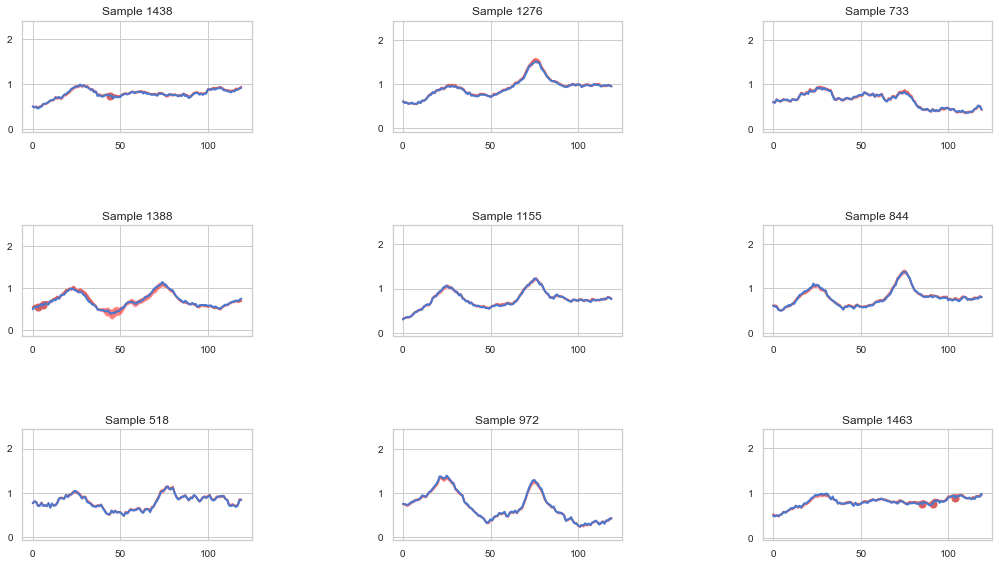

In [9]:
plot_sequences(model_NS, PLOT_DATA=train_dataset,samples=[1438,1276,733,1388,1155,844,518,972,1463])

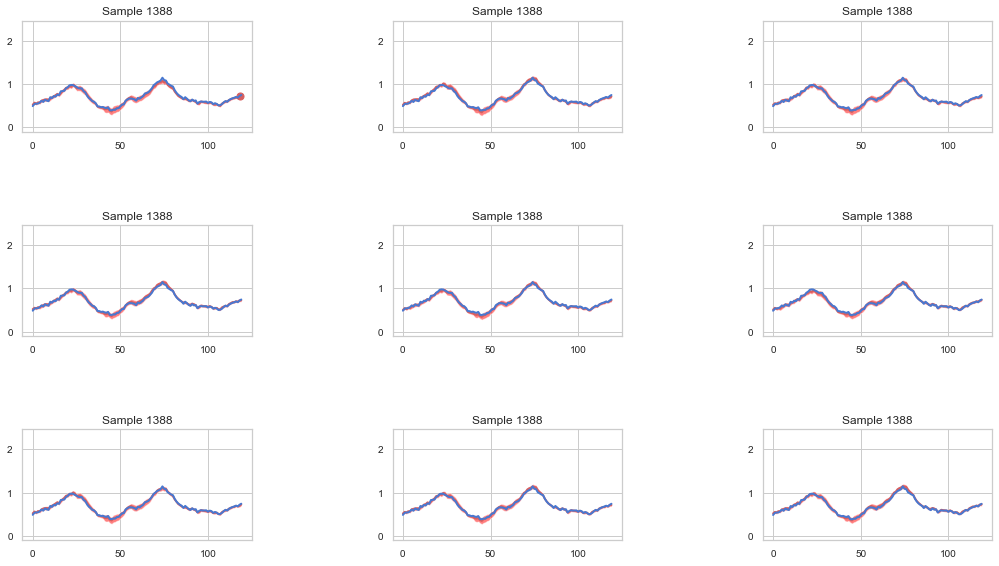

In [11]:
plot_sequences(model_NS, PLOT_DATA=train_dataset,samples=[1388,1388,1388,1388,1388,1388,1388,1388,1388])

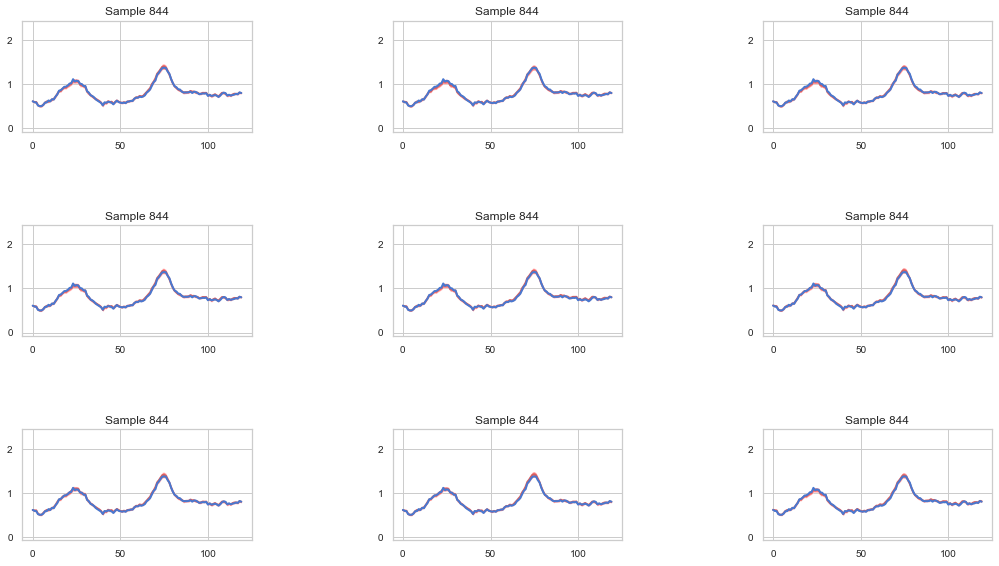

In [19]:
plot_sequences(model_NS, PLOT_DATA=train_dataset,samples=[844,844,844,844,844,844,844,844,844])

## LOAD BASELINE

In [12]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, hidden_dim=50, latent_features=16, num_layers=1, bidirectional=True):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.latent_features = latent_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        torch.manual_seed(0)
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        self.fc1 = nn.Linear(
            in_features=self.hidden_dim + int(self.bidirectional) * self.hidden_dim,
            out_features=100)
        
        self.fc2 = nn.Linear(
            in_features=100,
            out_features=2*latent_features)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        x, (hidden_n, _) = self.lstm(x)

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]
        
        #print(hidden_n.shape)

        hidden_n = hidden_n.reshape(batch_size, -1)
        
        #(batch, hidden) -> (batch, 2*latent)
        x = self.fc1(hidden_n)
        x = self.fc2(self.relu(x))

        return x.view(-1, 2*self.latent_features)

class Decoder(nn.Module):

    def __init__(self, seq_len, n_features=1, hidden_dim=50, latent_features=16, num_layers=1, bidirectional=True):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.latent_features = latent_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_features, self.hidden_dim)
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
        if torch.cuda.is_available():
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)
        else:
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.FloatTensor)


        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)
        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")
        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

In [13]:
with open('model_baseline.pkl', 'rb') as f:
    state_dict_loaded = torch.load(f, map_location=torch.device('cpu'))

In [14]:
encoder_base = Encoder(**state_dict_loaded["encoder_decoder_params"]).to("cpu")
decoder_base = Decoder(**state_dict_loaded["encoder_decoder_params"]).to("cpu")
model_base = BaseLSTM_VAEprob(encoder=encoder_base, decoder=decoder_base, **state_dict_loaded["model_params"]).to("cpu")
model_base.load_state_dict(state_dict_loaded["model"]())

<All keys matched successfully>

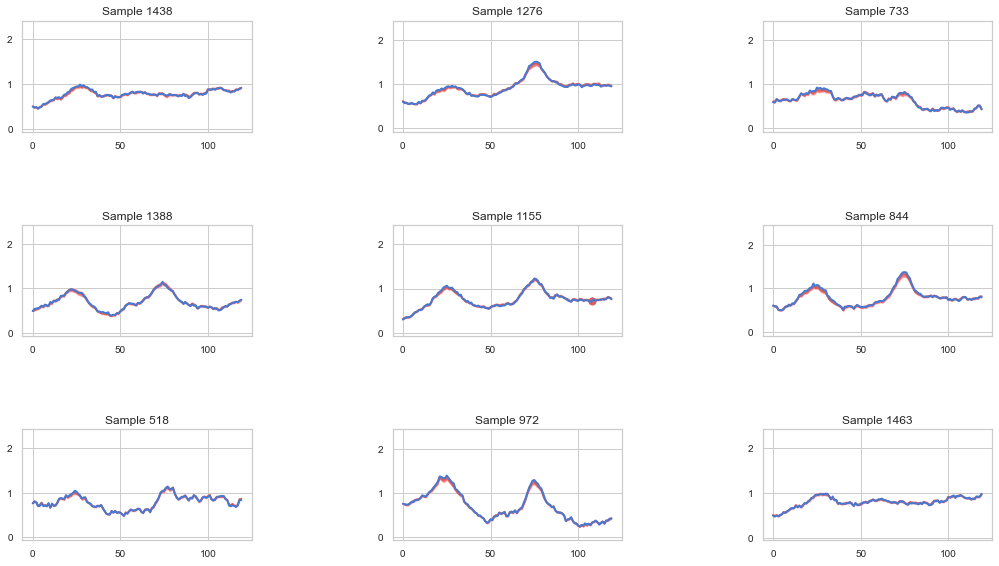

In [16]:
plot_sequences(model_base, PLOT_DATA=train_dataset,samples=[1438,1276,733,1388,1155,844,518,972,1463])

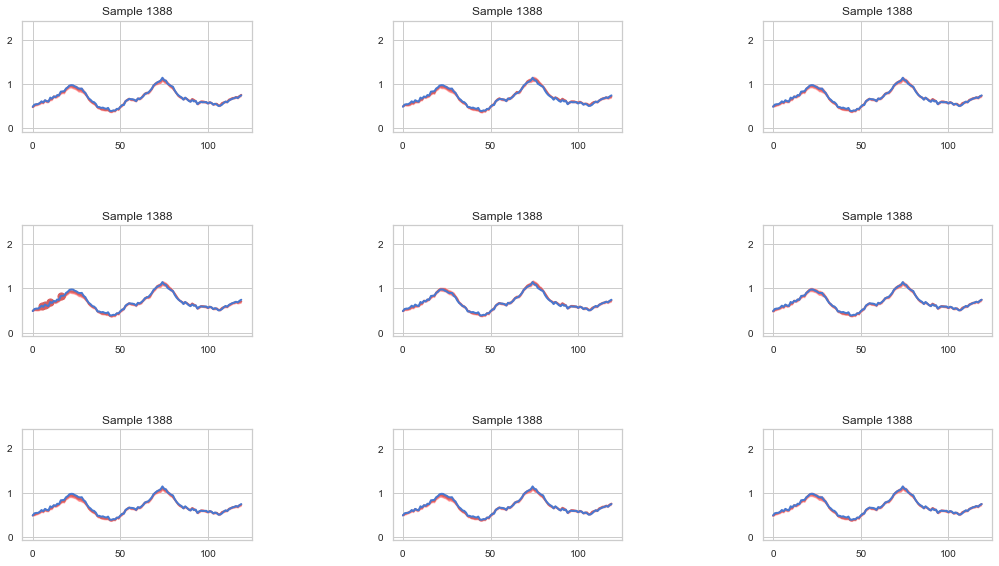

In [17]:
plot_sequences(model_base, PLOT_DATA=train_dataset,samples=[1388,1388,1388,1388,1388,1388,1388,1388,1388])

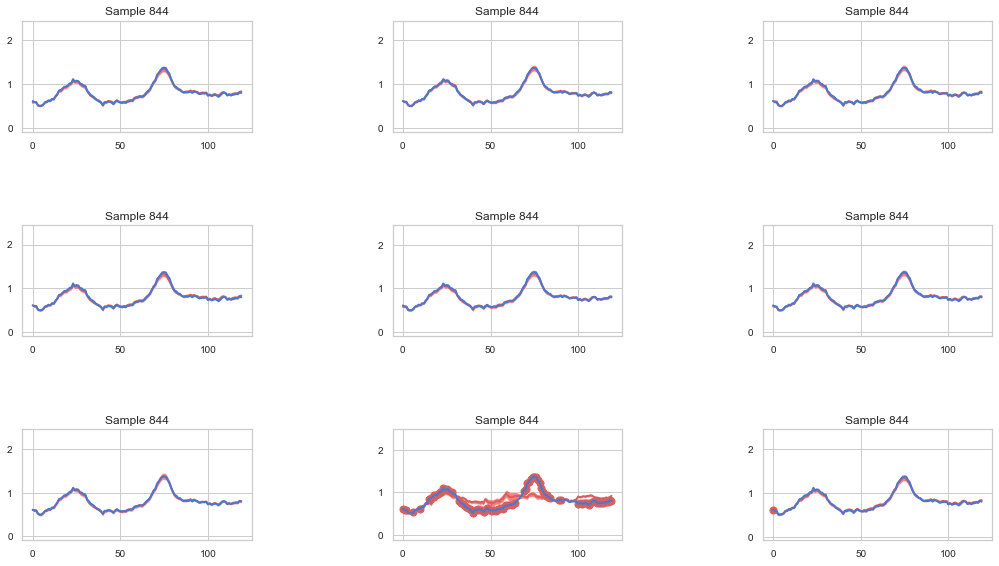

In [18]:
plot_sequences(model_base, PLOT_DATA=train_dataset,samples=[844,844,844,844,844,844,844,844,844])